# Reconstruction of volume from simulated data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.emfiles import crop_fourier_images, crop_fourier_volume
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
import jax

from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
from pyfftw.builders import irfft2

plt.rcParams["figure.figsize"]=8,8

### Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

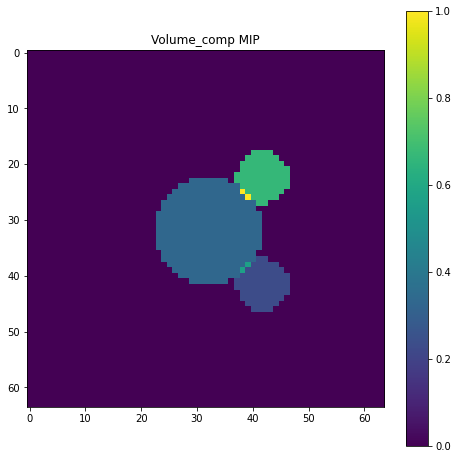

In [3]:
nx = 64
shape = np.array([nx,nx,nx])
dimensions = np.array([20,20,20])
pixel_size = dimensions[0]/shape[0]

# A volume with components
centres = np.array([[0,0,0], [3, 3, 0], [3, -3, 0]])
radii = np.array([3, 1.5, 1.5])
intensities = np.array([10,7,20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False))
vol_fourier, x_grid, _ = volume_fourier(vol, pixel_size)

y_grid = x_grid
z_grid = x_grid

mip_z(vol)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

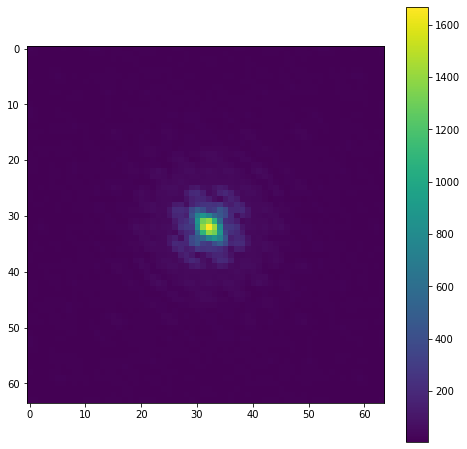

In [4]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()

### Generate the data

CTF

In [5]:
df = star.parse_star("../external/pyem/pyem.star", keep_index = False)
dfiter = df.iterrows()
_, p = next(dfiter)

#ctf_params = {'def1'  : p[star.Relion.DEFOCUSU], 
#              'def2'  : p[star.Relion.DEFOCUSV],
#              'angast': p[star.Relion.DEFOCUSANGLE], 
#              'phase' : p[star.Relion.PHASESHIFT],
#              'kv'    : p[star.Relion.VOLTAGE],
#              'ac'    : p[star.Relion.AC], 
#              'cs'    : p[star.Relion.CS], 
#              'bf'    : 0,
#              'lp'    : 2 * pixel_size}

ctf_params0 = np.array([p[star.Relion.DEFOCUSU],
                      p[star.Relion.DEFOCUSV],
                      p[star.Relion.DEFOCUSANGLE], 
                      p[star.Relion.PHASESHIFT],
                      p[star.Relion.VOLTAGE],
                      p[star.Relion.AC],
                      p[star.Relion.CS],
                      0,
                      2 * pixel_size])

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:532: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_NAME].str.split("@").str
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:540: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_ORIGINAL_NAME].str.split("@").str


Generate projections (in Fourier domain)

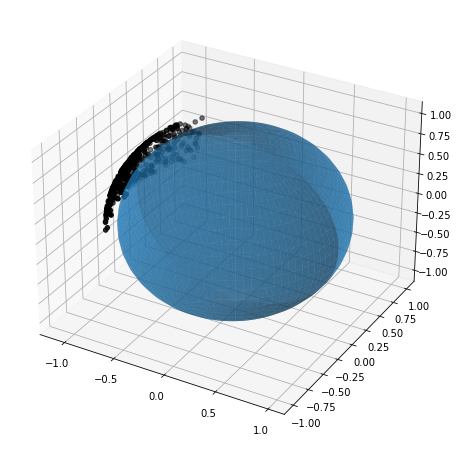

In [61]:
# Orientations
N = 1000

#s = 0.05
s = 0.1
#angles_true = jnp.array(np.random.rand(N,3))*jnp.pi*2

angles_true = jnp.array(np.random.rand(N,3))*jnp.pi/4 + jnp.pi

# Non uniformly distributed orientations (here, two clusters)
#angles_true = s*np.random.randn(int(N),3)
#angles_true = np.concatenate([s*np.random.randn(int(N/2),3), s*np.random.randn(int(N/2),3)+np.pi], axis=0)
#np.random.shuffle(angles_true)
#angles_true = jnp.array(angles_true)

#angles_true = np.zeros([N,3])
#angles_true[:,1] = s*np.random.randn(N) - np.pi/2
#angles_true = jnp.array(angles_true)

plot_angles(angles_true[:500])

1.4210307598114014


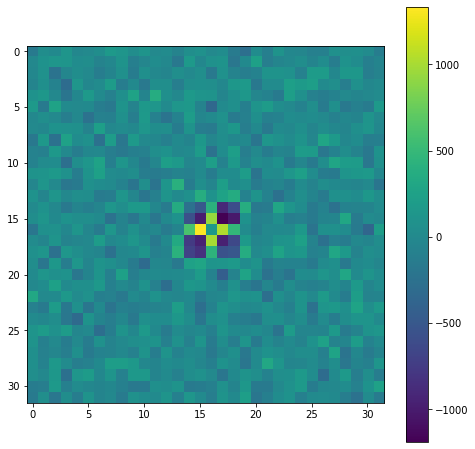

In [62]:
radius = 10
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array = get_slice_funcs(project, x_grid, mask, "tri")

img0 = slice_func(vol_fourier, [0,0,0], [0,0], ctf_params0)


shifts_true = jnp.zeros([N,3])
ctf_params = jnp.array([ctf_params0] * N)
start = time.time()
imgs = slice_func_array(vol_fourier, angles_true, shifts_true, ctf_params)

# Noise
imgs += (np.random.randn(N, nx*nx) + 1j*np.random.randn(N, nx*nx)) * jnp.max(img0) *0.1

print(time.time()-start)

plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

### Crop images and volume:

In [63]:
old_nx = jnp.sqrt(imgs.shape[1]).astype(jnp.int64)
nx = 32
imgs = imgs.reshape(imgs.shape[0], old_nx, old_nx)
imgs, x_grid = crop_fourier_images(imgs, x_grid, nx)
imgs = imgs.reshape(imgs.shape[0], nx*nx)

vol_fourier, _ = crop_fourier_volume(vol_fourier, x_grid, nx)

y_grid = x_grid
z_grid = x_grid

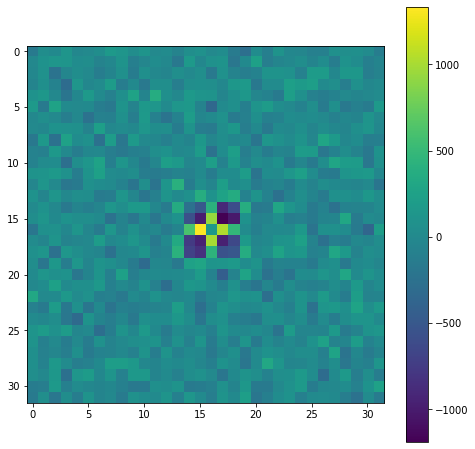

In [64]:
plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

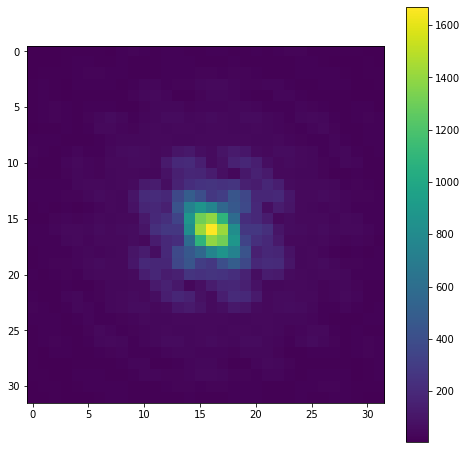

In [65]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()

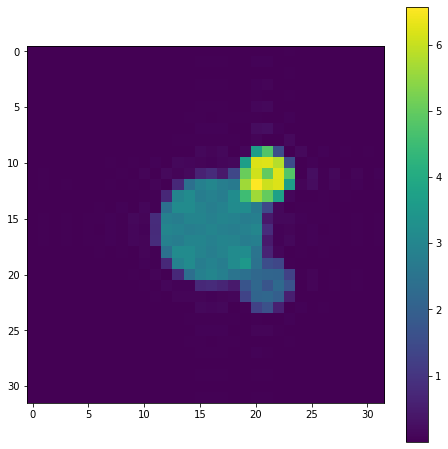

In [66]:
mip_z(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier)))); plt.colorbar()

### Loss functions for the new dimension

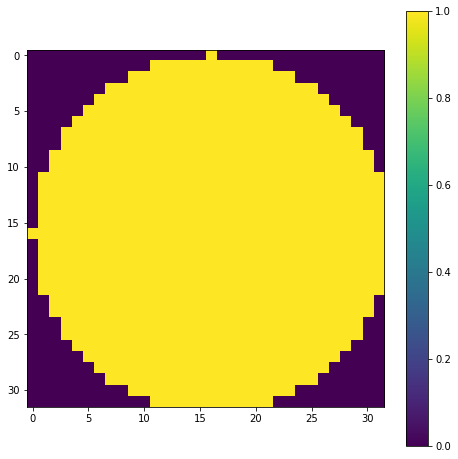

In [67]:
alpha = 0.001

radius = 0.8
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

In [68]:
start = time.time()
ll = loss_func_batched(np.random.randn(nx,nx,nx), angles_true[:20], shifts_true[:20], ctf_params[:20], imgs[:20])
print(time.time()-start)
print(ll.shape)

1.2922866344451904
(20,)


Gradients with respect to volume pixels, over all (or a batch of) images

In [69]:
start = time.time()
ll = grad_loss_volume(np.random.randn(nx,nx,nx), angles_true[0],  shifts_true[0], ctf_params[0], imgs[0])
print(time.time()-start)
print(ll.shape)

1.11574125289917
(32, 32, 32)


Doing the below with N large enough (e.g. 1000) makes it run out of memory (trying to allocate >200GB)

In [70]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(np.random.randn(nx,nx,nx), angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx])
print(time.time()-start)
print(ll.shape)

1.264503002166748
(32, 32, 32)


## Optimization with respect to volume

### CG - applied to two halves of the data

In [71]:
from src.algorithm import conjugate_gradient, get_cg_vol_ops

v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
N_iter = 100

N2 = jnp.floor(N/2).astype(jnp.int64)
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[:N2], shifts_true[:N2], ctf_params[:N2], imgs[:N2], v0.shape)

vcg1,_ = conjugate_gradient(AA1, Ab1, v0, N_iter, verbose = True)

Iter 0 ||r|| = 0.5576109303965883
Iter 1 ||r|| = 0.21743767849076195
Iter 2 ||r|| = 0.14858939030425095
Iter 3 ||r|| = 0.09809737744638242
Iter 4 ||r|| = 0.06770501799175198
Iter 5 ||r|| = 0.06607235503469831
Iter 6 ||r|| = 0.05730125458974471
Iter 7 ||r|| = 0.040727549290973074
Iter 8 ||r|| = 0.03538152569596708
Iter 9 ||r|| = 0.029229800459072815
Iter 10 ||r|| = 0.025365688499546696
Iter 11 ||r|| = 0.022565747843569572
Iter 12 ||r|| = 0.019799260080163205
Iter 13 ||r|| = 0.019287882309266938
Iter 14 ||r|| = 0.018468411644582336
Iter 15 ||r|| = 0.01421520666511868
Iter 16 ||r|| = 0.013985096345309348
Iter 17 ||r|| = 0.011484363735355918
Iter 18 ||r|| = 0.010745824586220523
Iter 19 ||r|| = 0.012026918583044166
Iter 20 ||r|| = 0.009575109933275691
Iter 21 ||r|| = 0.00817336266389767
Iter 22 ||r|| = 0.006907339153006471
Iter 23 ||r|| = 0.006811793821074804
Iter 24 ||r|| = 0.006355712586800854
Iter 25 ||r|| = 0.006316664646865721
Iter 26 ||r|| = 0.0048792852582591525
Iter 27 ||r|| = 0.004

In [72]:
AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[N2:], shifts_true[N2:], ctf_params[N2:], imgs[N2:], v0.shape)

vcg2, _ = conjugate_gradient(AA2, Ab2, v0, N_iter, verbose = True)

Iter 0 ||r|| = 0.543647090066466
Iter 1 ||r|| = 0.21467791917615844
Iter 2 ||r|| = 0.14205543659140904
Iter 3 ||r|| = 0.09454782497391719
Iter 4 ||r|| = 0.06590724352667637
Iter 5 ||r|| = 0.06427290919505549
Iter 6 ||r|| = 0.05616037884353374
Iter 7 ||r|| = 0.03930210265928165
Iter 8 ||r|| = 0.0337849429892881
Iter 9 ||r|| = 0.028543186220816
Iter 10 ||r|| = 0.02410324686295112
Iter 11 ||r|| = 0.021919510624616466
Iter 12 ||r|| = 0.020048685925055734
Iter 13 ||r|| = 0.019319467210041852
Iter 14 ||r|| = 0.01703710771972092
Iter 15 ||r|| = 0.013093606839308628
Iter 16 ||r|| = 0.012515885600779783
Iter 17 ||r|| = 0.011480032989825702
Iter 18 ||r|| = 0.010083692507720144
Iter 19 ||r|| = 0.010408290103431339
Iter 20 ||r|| = 0.009596613612773607
Iter 21 ||r|| = 0.007473252317390553
Iter 22 ||r|| = 0.006609081425204941
Iter 23 ||r|| = 0.006314024608357009
Iter 24 ||r|| = 0.007183844727565983
Iter 25 ||r|| = 0.005278828275185333
Iter 26 ||r|| = 0.004689749963685955
Iter 27 ||r|| = 0.0044970787

In [73]:
#print("Final loss function = ", loss_func_sum(vcg, angles_true, shifts_true, ctf_params, imgs))
print("Relative error = ", jnp.max(jnp.abs((vcg1 - vol_fourier)/jnp.max(vol_fourier))))
print("Absolute error = ", jnp.mean(jnp.abs((vcg1 - vol_fourier))))

Relative error =  0.788447037579668
Absolute error =  33.30434774954312


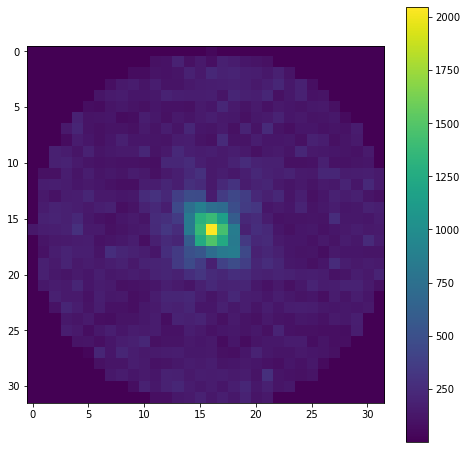

In [74]:
mip_z(jnp.abs(jnp.fft.fftshift((vcg1)))) ; plt.colorbar()

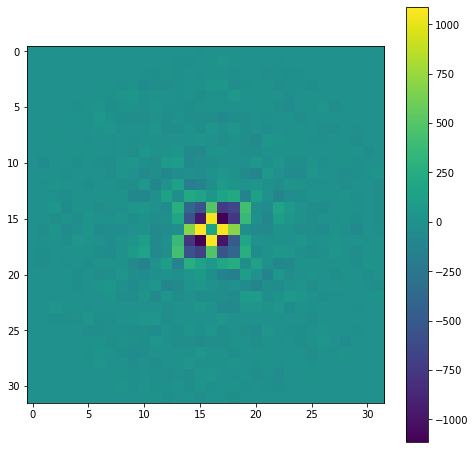

In [75]:
idx = 709

s0 = slice_func(vcg1, angles_true[idx], shifts_true[idx], ctf_params[idx])
plt.imshow(jnp.fft.fftshift(jnp.real(s0).reshape(nx,nx))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

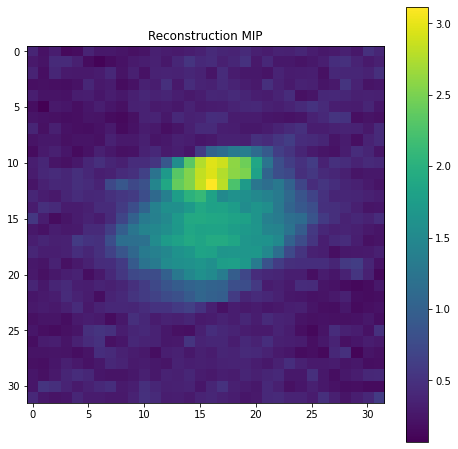

In [76]:
mip_y(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction MIP')

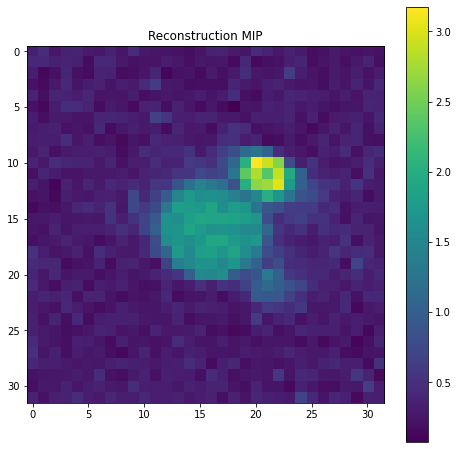

In [77]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg2))))
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

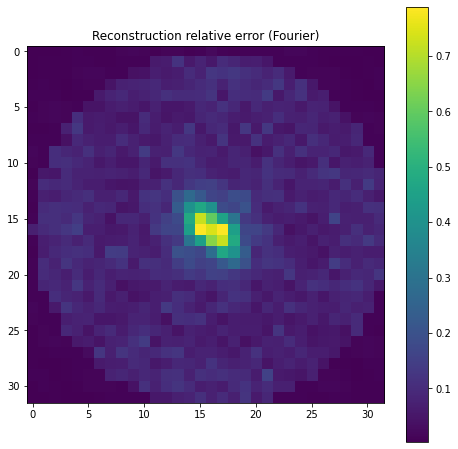

In [78]:
mip_z(jnp.abs(jnp.fft.fftshift((vcg1-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

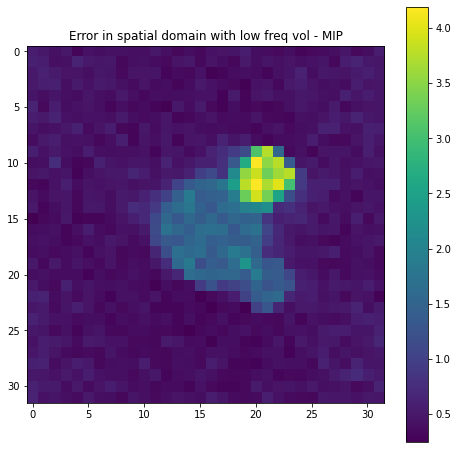

In [79]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier - vcg1)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

### FSC

In [80]:
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid, dr = 0.05)

In [81]:
points_v_tri = points_orientations_tri(angles_true, x_grid, y_grid, z_grid)
points_v_nn = points_orientations_nn(angles_true, x_grid, y_grid, z_grid)

In [82]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr = 0.05)

Text(0.5, 1.0, 'Clustered angles')

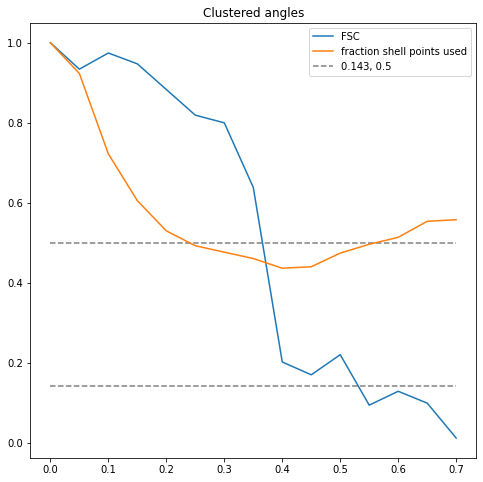

In [83]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
plt.title('Clustered angles')

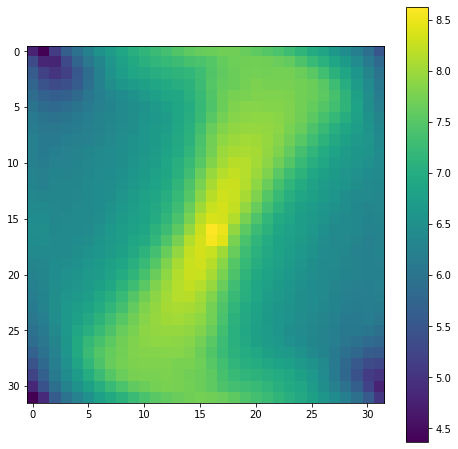

In [84]:
plt.imshow(jnp.fft.fftshift(jnp.log(points_v_tri[:,:,0]))); plt.colorbar()

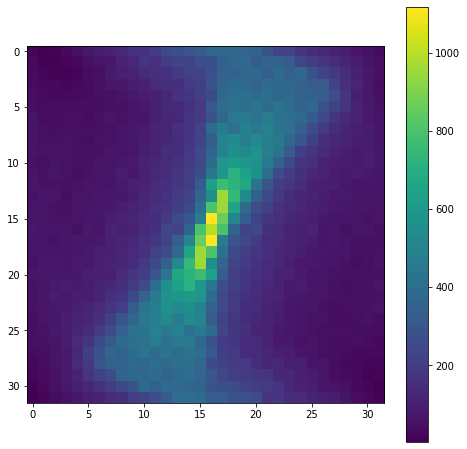

In [137]:
plt.imshow(jnp.fft.fftshift(points_v_nn[:,:,0])); plt.colorbar()

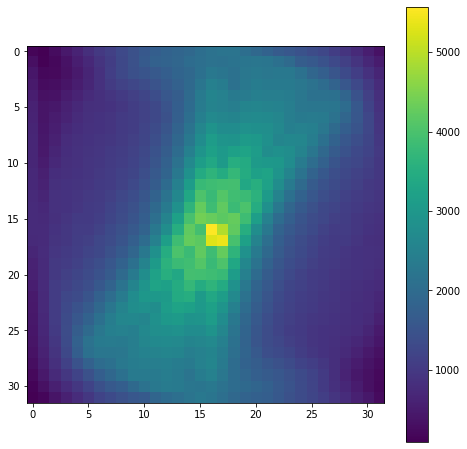

In [138]:
mip_z((np.fft.fftshift(points_v_tri)))
plt.colorbar()

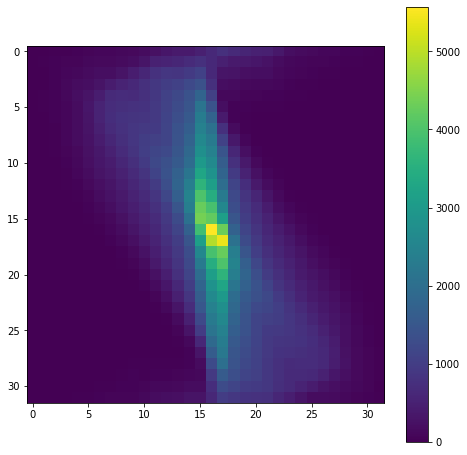

In [87]:
mip_x((np.fft.fftshift(points_v_tri)))
plt.colorbar()

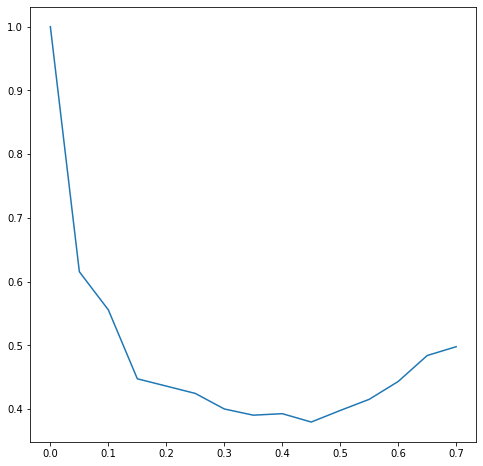

In [88]:
res_spu, spu_nn = shell_points_used(points_v_nn, x_grid, dr = 0.05)
plt.plot(res_spu, spu_nn)

### James

The mean is given by CG as applied above, in addition we need to calculate the variances.
The variances are given by the inverse of the gradient (AA) applied to diag(1), i.e. a volume with ones.

Looks good and agrees with counting the points above, but for whatever reason it's mirrored compared to above hmmm.

In [165]:
vones = jnp.ones(vcg1.shape)
omega = AA1(vones)
omega = 1/omega
#omega = omega/jnp.max(jnp.abs(omega))

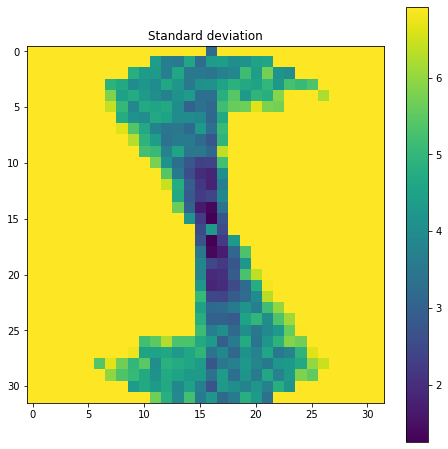

In [166]:
plt.title("Standard deviation")
plt.imshow(jnp.log(jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,0,:]))))); plt.colorbar()

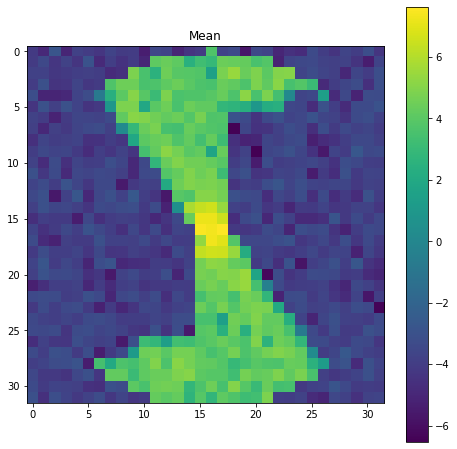

In [167]:
plt.title("Mean")
plt.imshow(jnp.log(jnp.abs(jnp.fft.fftshift(vcg1[:,0,:])))); plt.colorbar()


### SGD

In [34]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
#v0 = vol_fourier + 0.1*v * mask
alpha = 10 # this alpha works well for full 128 x 128 x 128 volume with mask
batch_size = 2
N_iter = 1000  
#N_iter = 1000 

v = v0
for i in range(N_iter):
    
    idx = np.random.default_rng().choice(N, size=batch_size, replace = False)
    
    if jnp.mod(i,100) == 0:
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(v, angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx]))))

    v = v - alpha * jnp.conj(grad_loss_volume_batched(v, angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx]))
    
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, shifts_true, ctf_params, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

Iter 0: mean loss = 22353.953195647813
Iter 100: mean loss = 19206.493325578114
Iter 200: mean loss = 17388.52876251129
Iter 300: mean loss = 17029.733548320266
Iter 400: mean loss = 16092.049358364864
Iter 500: mean loss = 14066.454771948562
Iter 600: mean loss = 14804.003164570706
Iter 700: mean loss = 13974.368539493573
Iter 800: mean loss = 15457.27920828691
Iter 900: mean loss = 14067.294540478397
Final loss function (over all data) =  14375.569583733335
Relative error =  0.5324425901571362


In [35]:
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, shifts_true, ctf_params, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

Final loss function (over all data) =  14375.569583733335
Relative error =  0.5324425901571362


Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

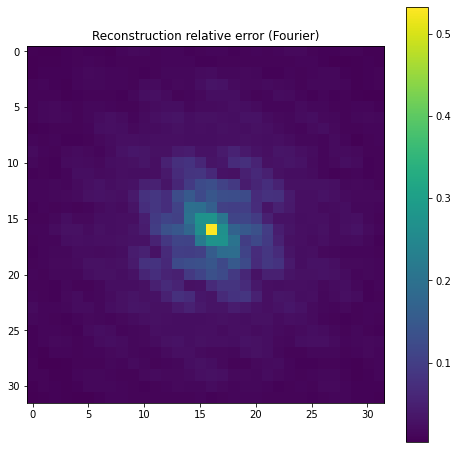

In [36]:
mip_z(jnp.abs(jnp.fft.fftshift((v-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Reconstruction MIP')

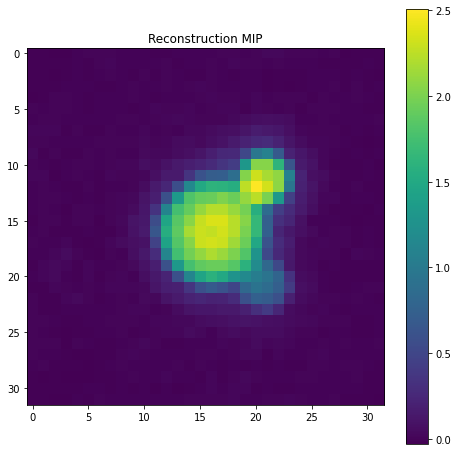

In [37]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v))))
plt.colorbar()
plt.title('Reconstruction MIP')

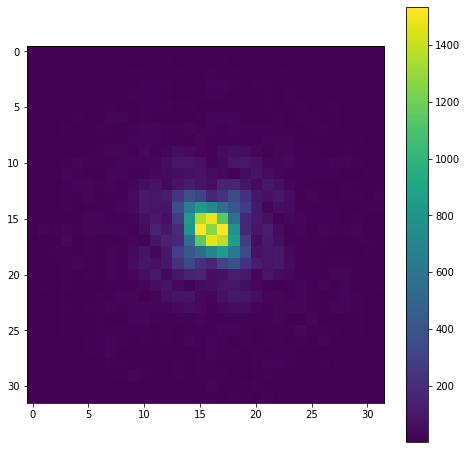

In [38]:
mip_z(jnp.abs(jnp.fft.fftshift((v)))) ; plt.colorbar()

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

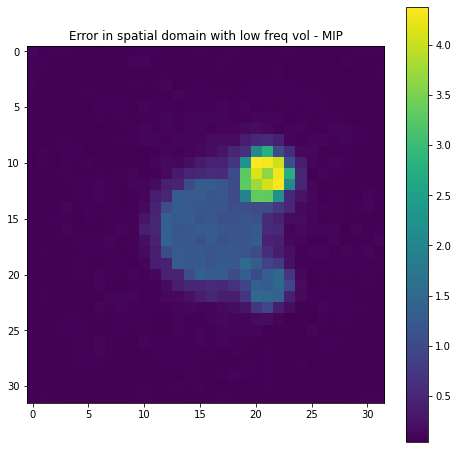

In [39]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier*mask - v*mask)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

And the error with the high freq volume

Text(0.5, 1.0, 'Reconstruction error with high freq vol -  MIP')

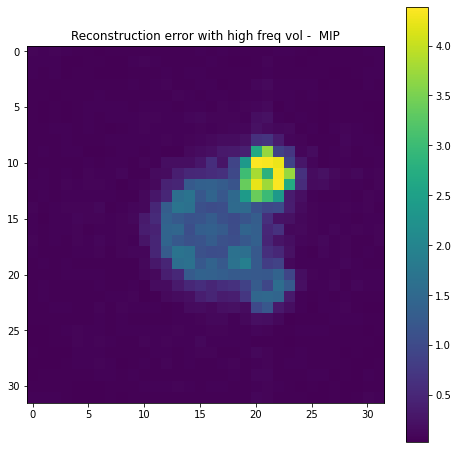

In [40]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - v)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')

Text(0.5, 1.0, 'Reconstruction error with high freq vol -  MIP')

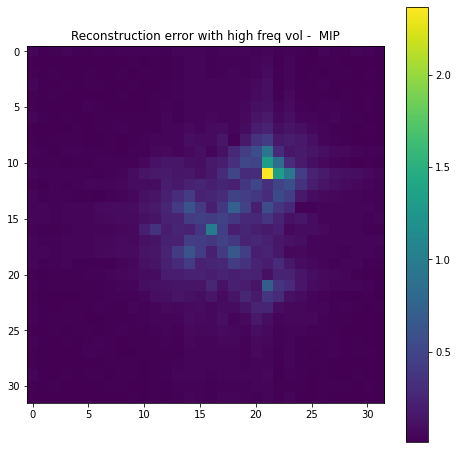

In [41]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - vol_fourier*mask)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')